In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='3'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='max_temp'
SAMPLE_SIZE=2500

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles-v1/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v1', 'profile_list_v1_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_3_20250331_0128


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v1_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 75584/75584 [00:15<00:00, 4728.41it/s]

Saved 75584 profiles to /workspace/outputs/profiles_v1_experiment_3_20250331_0128/20250331-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 75584it [00:02, 25965.66it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250331_0128/density_plot.png


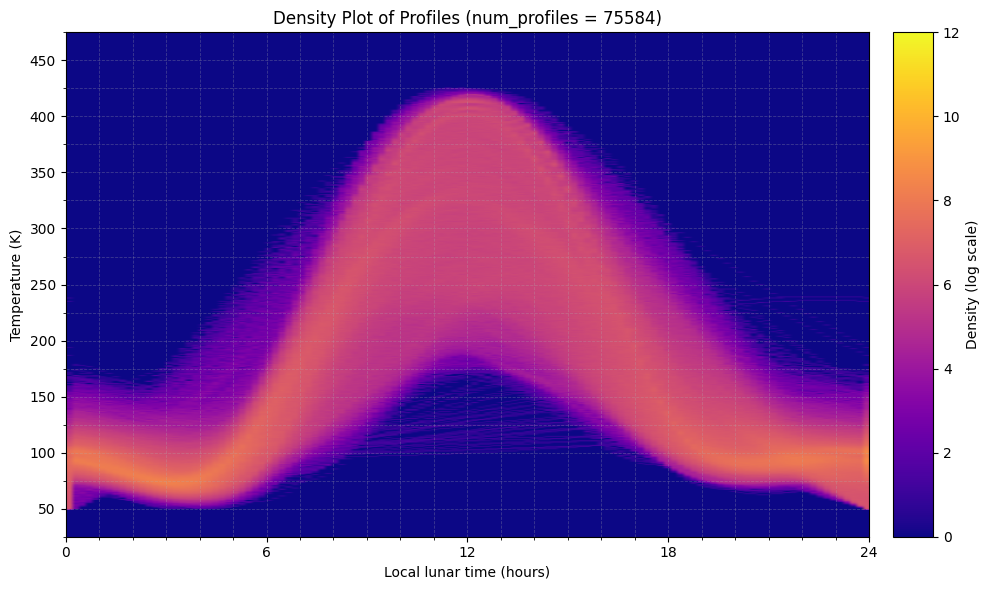

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250331_0128/histogram_max_temp.png


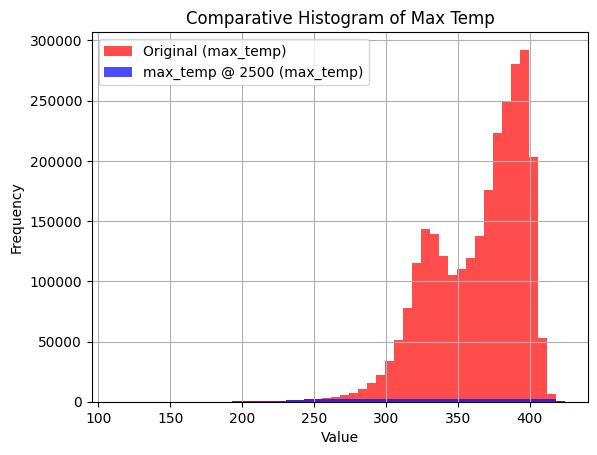

Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250331_0128/histogram_min_temp.png


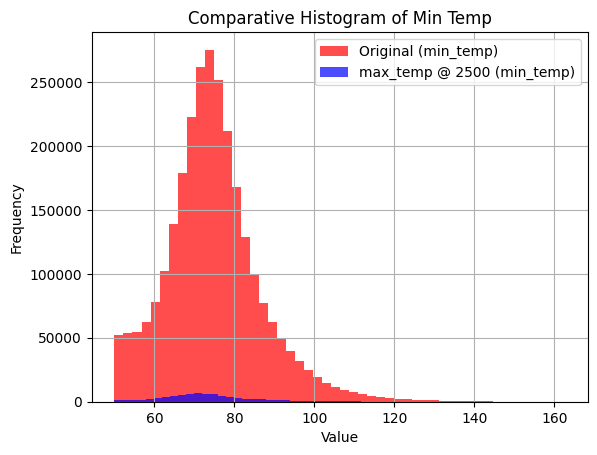

Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250331_0128/histogram_mean_temp.png


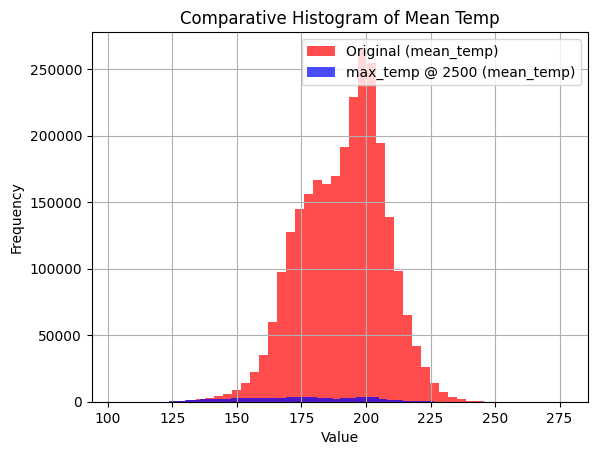

Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250331_0128/histogram_std_temp.png


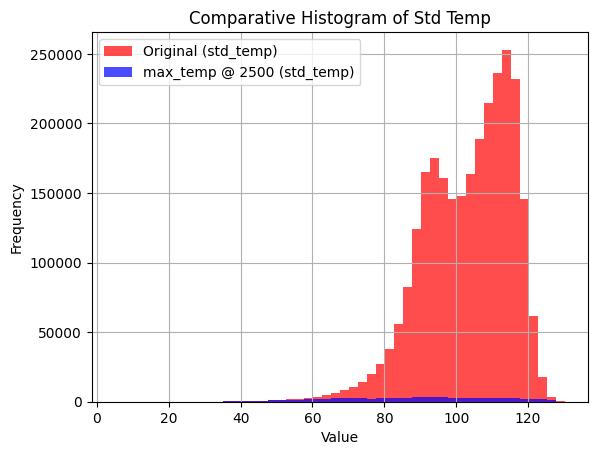

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 174.4967
STD: 93.8218
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 52908
Validation Data: 15116
Test Data: 7560


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 265/265 [00:08<00:00, 31.62it/s, best_loss=0.6226]


[Training] Epoch 1/100, L1 Loss: 0.6412, L2 Loss: 0.6665, KL Loss: 0.4733, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 76/76 [00:00<00:00, 108.84it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5262, Val L2 Loss: 0.4992, Val KL Loss: 0.7983
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_3_20250331_0128'


[Training] Epoch 2/100: 100%|██████████| 265/265 [00:08<00:00, 31.40it/s, best_loss=0.6032]


[Training] Epoch 2/100, L1 Loss: 0.5747, L2 Loss: 0.5524, KL Loss: 0.6240, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 76/76 [00:00<00:00, 104.37it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5366, Val L2 Loss: 0.5063, Val KL Loss: 0.6043


[Training] Epoch 3/100: 100%|██████████| 265/265 [00:08<00:00, 30.67it/s, best_loss=0.5785]


[Training] Epoch 3/100, L1 Loss: 0.5743, L2 Loss: 0.5515, KL Loss: 0.6202, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 76/76 [00:00<00:00, 107.73it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5041, Val KL Loss: 0.6218


[Training] Epoch 4/100: 100%|██████████| 265/265 [00:08<00:00, 31.39it/s, best_loss=0.5928]


[Training] Epoch 4/100, L1 Loss: 0.5740, L2 Loss: 0.5510, KL Loss: 0.6216, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 76/76 [00:00<00:00, 97.55it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5301, Val L2 Loss: 0.5013, Val KL Loss: 0.6332


[Training] Epoch 5/100: 100%|██████████| 265/265 [00:08<00:00, 30.79it/s, best_loss=0.6081]


[Training] Epoch 5/100, L1 Loss: 0.5736, L2 Loss: 0.5506, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 76/76 [00:00<00:00, 104.66it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5350, Val L2 Loss: 0.5049, Val KL Loss: 0.6142


[Training] Epoch 6/100: 100%|██████████| 265/265 [00:08<00:00, 31.30it/s, best_loss=0.5974]


[Training] Epoch 6/100, L1 Loss: 0.5734, L2 Loss: 0.5502, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 76/76 [00:00<00:00, 114.08it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5327, Val L2 Loss: 0.5033, Val KL Loss: 0.6264


[Training] Epoch 7/100: 100%|██████████| 265/265 [00:08<00:00, 30.39it/s, best_loss=0.5694]


[Training] Epoch 7/100, L1 Loss: 0.5737, L2 Loss: 0.5505, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 76/76 [00:00<00:00, 105.84it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5350, Val L2 Loss: 0.5053, Val KL Loss: 0.6115


[Training] Epoch 8/100: 100%|██████████| 265/265 [00:08<00:00, 29.61it/s, best_loss=0.5811]


[Training] Epoch 8/100, L1 Loss: 0.5736, L2 Loss: 0.5505, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 76/76 [00:00<00:00, 111.33it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5385, Val L2 Loss: 0.5083, Val KL Loss: 0.6092


[Training] Epoch 9/100: 100%|██████████| 265/265 [00:08<00:00, 31.24it/s, best_loss=0.5942]


[Training] Epoch 9/100, L1 Loss: 0.5744, L2 Loss: 0.5515, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 76/76 [00:00<00:00, 106.98it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5334, Val L2 Loss: 0.5042, Val KL Loss: 0.6176


[Training] Epoch 10/100: 100%|██████████| 265/265 [00:08<00:00, 32.19it/s, best_loss=0.5754]


[Training] Epoch 10/100, L1 Loss: 0.5738, L2 Loss: 0.5510, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 76/76 [00:00<00:00, 77.27it/s] 


[Validation] Epoch 10/100, Val L1 Loss: 0.5372, Val L2 Loss: 0.5071, Val KL Loss: 0.6094


[Training] Epoch 11/100: 100%|██████████| 265/265 [00:08<00:00, 31.56it/s, best_loss=0.5989]


[Training] Epoch 11/100, L1 Loss: 0.5739, L2 Loss: 0.5504, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 76/76 [00:00<00:00, 104.19it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5370, Val L2 Loss: 0.5068, Val KL Loss: 0.6111


[Training] Epoch 12/100: 100%|██████████| 265/265 [00:08<00:00, 31.33it/s, best_loss=0.5806]


[Training] Epoch 12/100, L1 Loss: 0.5739, L2 Loss: 0.5506, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 76/76 [00:00<00:00, 110.48it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5298, Val L2 Loss: 0.5012, Val KL Loss: 0.6253


[Training] Epoch 13/100: 100%|██████████| 265/265 [00:08<00:00, 31.98it/s, best_loss=0.5815]


[Training] Epoch 13/100, L1 Loss: 0.5735, L2 Loss: 0.5500, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 76/76 [00:00<00:00, 108.97it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5021, Val KL Loss: 0.6243


[Training] Epoch 14/100: 100%|██████████| 265/265 [00:08<00:00, 30.69it/s, best_loss=0.6067]


[Training] Epoch 14/100, L1 Loss: 0.5741, L2 Loss: 0.5510, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 76/76 [00:00<00:00, 102.13it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5029, Val KL Loss: 0.6210


[Training] Epoch 15/100: 100%|██████████| 265/265 [00:08<00:00, 30.45it/s, best_loss=0.5322]


[Training] Epoch 15/100, L1 Loss: 0.5733, L2 Loss: 0.5498, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 76/76 [00:00<00:00, 108.47it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5306, Val L2 Loss: 0.5015, Val KL Loss: 0.6254


[Training] Epoch 16/100: 100%|██████████| 265/265 [00:08<00:00, 31.39it/s, best_loss=0.5882]


[Training] Epoch 16/100, L1 Loss: 0.5737, L2 Loss: 0.5507, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 76/76 [00:00<00:00, 92.30it/s] 


[Validation] Epoch 16/100, Val L1 Loss: 0.5331, Val L2 Loss: 0.5034, Val KL Loss: 0.6237


[Training] Epoch 17/100: 100%|██████████| 265/265 [00:08<00:00, 31.62it/s, best_loss=0.5908]


[Training] Epoch 17/100, L1 Loss: 0.5728, L2 Loss: 0.5497, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 76/76 [00:00<00:00, 92.06it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5003, Val KL Loss: 0.6276


[Training] Epoch 18/100: 100%|██████████| 265/265 [00:08<00:00, 29.54it/s, best_loss=0.5802]


[Training] Epoch 18/100, L1 Loss: 0.5739, L2 Loss: 0.5510, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 76/76 [00:00<00:00, 101.62it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5030, Val KL Loss: 0.6212


[Training] Epoch 19/100: 100%|██████████| 265/265 [00:08<00:00, 32.27it/s, best_loss=0.5952]


[Training] Epoch 19/100, L1 Loss: 0.5733, L2 Loss: 0.5507, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 76/76 [00:00<00:00, 109.78it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5019, Val KL Loss: 0.6240


[Training] Epoch 20/100: 100%|██████████| 265/265 [00:08<00:00, 30.92it/s, best_loss=0.6002]


[Training] Epoch 20/100, L1 Loss: 0.5736, L2 Loss: 0.5504, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 76/76 [00:00<00:00, 106.96it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5325, Val L2 Loss: 0.5035, Val KL Loss: 0.6204


[Training] Epoch 21/100: 100%|██████████| 265/265 [00:08<00:00, 31.04it/s, best_loss=0.6052]


[Training] Epoch 21/100, L1 Loss: 0.5737, L2 Loss: 0.5505, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 76/76 [00:00<00:00, 98.16it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5024, Val KL Loss: 0.6233


[Training] Epoch 22/100: 100%|██████████| 265/265 [00:08<00:00, 30.20it/s, best_loss=0.5788]


[Training] Epoch 22/100, L1 Loss: 0.5736, L2 Loss: 0.5506, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 76/76 [00:00<00:00, 113.74it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5356, Val L2 Loss: 0.5054, Val KL Loss: 0.6137


[Training] Epoch 23/100: 100%|██████████| 265/265 [00:08<00:00, 32.01it/s, best_loss=0.5659]


[Training] Epoch 23/100, L1 Loss: 0.5734, L2 Loss: 0.5501, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 76/76 [00:00<00:00, 106.08it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5350, Val L2 Loss: 0.5051, Val KL Loss: 0.6160


[Training] Epoch 24/100: 100%|██████████| 265/265 [00:08<00:00, 30.98it/s, best_loss=0.5908]


[Training] Epoch 24/100, L1 Loss: 0.5736, L2 Loss: 0.5506, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 76/76 [00:00<00:00, 108.97it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5365, Val L2 Loss: 0.5064, Val KL Loss: 0.6109


[Training] Epoch 25/100: 100%|██████████| 265/265 [00:08<00:00, 31.94it/s, best_loss=0.5995]


[Training] Epoch 25/100, L1 Loss: 0.5735, L2 Loss: 0.5502, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 76/76 [00:00<00:00, 99.39it/s] 


[Validation] Epoch 25/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5019, Val KL Loss: 0.6225


[Training] Epoch 26/100: 100%|██████████| 265/265 [00:08<00:00, 30.20it/s, best_loss=0.5780]


[Training] Epoch 26/100, L1 Loss: 0.5737, L2 Loss: 0.5507, KL Loss: 0.6216, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 76/76 [00:00<00:00, 109.46it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5346, Val L2 Loss: 0.5048, Val KL Loss: 0.6163


[Training] Epoch 27/100: 100%|██████████| 265/265 [00:08<00:00, 31.22it/s, best_loss=0.5904]


[Training] Epoch 27/100, L1 Loss: 0.5735, L2 Loss: 0.5501, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 76/76 [00:00<00:00, 106.76it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5340, Val L2 Loss: 0.5047, Val KL Loss: 0.6178


[Training] Epoch 28/100: 100%|██████████| 265/265 [00:08<00:00, 32.45it/s, best_loss=0.5703]


[Training] Epoch 28/100, L1 Loss: 0.5735, L2 Loss: 0.5503, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 76/76 [00:00<00:00, 115.70it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5334, Val L2 Loss: 0.5039, Val KL Loss: 0.6210


[Training] Epoch 29/100: 100%|██████████| 265/265 [00:08<00:00, 32.49it/s, best_loss=0.5952]


[Training] Epoch 29/100, L1 Loss: 0.5735, L2 Loss: 0.5502, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 76/76 [00:00<00:00, 111.02it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5341, Val L2 Loss: 0.5053, Val KL Loss: 0.6132


[Training] Epoch 30/100: 100%|██████████| 265/265 [00:08<00:00, 31.14it/s, best_loss=0.5995]


[Training] Epoch 30/100, L1 Loss: 0.5740, L2 Loss: 0.5509, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 76/76 [00:00<00:00, 113.49it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5322, Val L2 Loss: 0.5029, Val KL Loss: 0.6236


[Training] Epoch 31/100: 100%|██████████| 265/265 [00:08<00:00, 32.24it/s, best_loss=0.5934]


[Training] Epoch 31/100, L1 Loss: 0.5739, L2 Loss: 0.5506, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 76/76 [00:00<00:00, 111.48it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5348, Val L2 Loss: 0.5049, Val KL Loss: 0.6159


[Training] Epoch 32/100: 100%|██████████| 265/265 [00:08<00:00, 32.76it/s, best_loss=0.5686]


[Training] Epoch 32/100, L1 Loss: 0.5736, L2 Loss: 0.5509, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 76/76 [00:00<00:00, 109.83it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5354, Val L2 Loss: 0.5059, Val KL Loss: 0.6121


[Training] Epoch 33/100: 100%|██████████| 265/265 [00:08<00:00, 32.51it/s, best_loss=0.5623]


[Training] Epoch 33/100, L1 Loss: 0.5738, L2 Loss: 0.5507, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 76/76 [00:00<00:00, 86.00it/s] 


[Validation] Epoch 33/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5027, Val KL Loss: 0.6252


[Training] Epoch 34/100: 100%|██████████| 265/265 [00:08<00:00, 32.89it/s, best_loss=0.5926]


[Training] Epoch 34/100, L1 Loss: 0.5737, L2 Loss: 0.5509, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 76/76 [00:00<00:00, 114.20it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5366, Val L2 Loss: 0.5071, Val KL Loss: 0.6034


[Training] Epoch 35/100: 100%|██████████| 265/265 [00:08<00:00, 32.45it/s, best_loss=0.5915]


[Training] Epoch 35/100, L1 Loss: 0.5734, L2 Loss: 0.5504, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 76/76 [00:00<00:00, 111.21it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5041, Val KL Loss: 0.6184


[Training] Epoch 36/100: 100%|██████████| 265/265 [00:08<00:00, 32.22it/s, best_loss=0.5828]


[Training] Epoch 36/100, L1 Loss: 0.5736, L2 Loss: 0.5500, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 76/76 [00:00<00:00, 111.48it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5013, Val KL Loss: 0.6298


[Training] Epoch 37/100: 100%|██████████| 265/265 [00:08<00:00, 31.63it/s, best_loss=0.5837]


[Training] Epoch 37/100, L1 Loss: 0.5734, L2 Loss: 0.5503, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 76/76 [00:00<00:00, 110.61it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5382, Val L2 Loss: 0.5082, Val KL Loss: 0.6039


[Training] Epoch 38/100: 100%|██████████| 265/265 [00:08<00:00, 31.91it/s, best_loss=0.5993]


[Training] Epoch 38/100, L1 Loss: 0.5740, L2 Loss: 0.5509, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 76/76 [00:00<00:00, 106.28it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5376, Val L2 Loss: 0.5074, Val KL Loss: 0.6038


[Training] Epoch 39/100: 100%|██████████| 265/265 [00:07<00:00, 34.02it/s, best_loss=0.6018]


[Training] Epoch 39/100, L1 Loss: 0.5735, L2 Loss: 0.5501, KL Loss: 0.6219, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 76/76 [00:00<00:00, 107.28it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5301, Val L2 Loss: 0.5011, Val KL Loss: 0.6283


[Training] Epoch 40/100: 100%|██████████| 265/265 [00:07<00:00, 33.36it/s, best_loss=0.6002]


[Training] Epoch 40/100, L1 Loss: 0.5737, L2 Loss: 0.5508, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 76/76 [00:00<00:00, 110.33it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5332, Val L2 Loss: 0.5035, Val KL Loss: 0.6219


[Training] Epoch 41/100: 100%|██████████| 265/265 [00:08<00:00, 31.66it/s, best_loss=0.5881]


[Training] Epoch 41/100, L1 Loss: 0.5740, L2 Loss: 0.5513, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 76/76 [00:00<00:00, 116.58it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5354, Val L2 Loss: 0.5061, Val KL Loss: 0.6080


[Training] Epoch 42/100: 100%|██████████| 265/265 [00:08<00:00, 32.11it/s, best_loss=0.6010]


[Training] Epoch 42/100, L1 Loss: 0.5735, L2 Loss: 0.5505, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 76/76 [00:00<00:00, 111.90it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5361, Val L2 Loss: 0.5059, Val KL Loss: 0.6139


[Training] Epoch 43/100: 100%|██████████| 265/265 [00:08<00:00, 32.03it/s, best_loss=0.5953]


[Training] Epoch 43/100, L1 Loss: 0.5735, L2 Loss: 0.5503, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 76/76 [00:00<00:00, 113.27it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5353, Val L2 Loss: 0.5059, Val KL Loss: 0.6113


[Training] Epoch 44/100: 100%|██████████| 265/265 [00:08<00:00, 32.43it/s, best_loss=0.5999]


[Training] Epoch 44/100, L1 Loss: 0.5730, L2 Loss: 0.5496, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 76/76 [00:00<00:00, 105.60it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5379, Val L2 Loss: 0.5077, Val KL Loss: 0.6098


[Training] Epoch 45/100: 100%|██████████| 265/265 [00:08<00:00, 31.38it/s, best_loss=0.5943]


[Training] Epoch 45/100, L1 Loss: 0.5736, L2 Loss: 0.5505, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 76/76 [00:00<00:00, 109.59it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5088, Val KL Loss: 0.6016


[Training] Epoch 46/100: 100%|██████████| 265/265 [00:08<00:00, 32.12it/s, best_loss=0.5851]


[Training] Epoch 46/100, L1 Loss: 0.5732, L2 Loss: 0.5501, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 76/76 [00:00<00:00, 110.09it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5360, Val L2 Loss: 0.5065, Val KL Loss: 0.6079


[Training] Epoch 47/100: 100%|██████████| 265/265 [00:08<00:00, 32.80it/s, best_loss=0.5821]


[Training] Epoch 47/100, L1 Loss: 0.5734, L2 Loss: 0.5507, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 76/76 [00:00<00:00, 111.02it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5333, Val L2 Loss: 0.5040, Val KL Loss: 0.6224


[Training] Epoch 48/100: 100%|██████████| 265/265 [00:08<00:00, 32.12it/s, best_loss=0.5865]


[Training] Epoch 48/100, L1 Loss: 0.5733, L2 Loss: 0.5501, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 76/76 [00:00<00:00, 106.48it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5353, Val L2 Loss: 0.5051, Val KL Loss: 0.6179


[Training] Epoch 49/100: 100%|██████████| 265/265 [00:08<00:00, 30.56it/s, best_loss=0.5877]


[Training] Epoch 49/100, L1 Loss: 0.5738, L2 Loss: 0.5507, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 76/76 [00:00<00:00, 110.51it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5022, Val KL Loss: 0.6273


[Training] Epoch 50/100: 100%|██████████| 265/265 [00:08<00:00, 31.92it/s, best_loss=0.5743]


[Training] Epoch 50/100, L1 Loss: 0.5733, L2 Loss: 0.5500, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 76/76 [00:00<00:00, 113.96it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5325, Val L2 Loss: 0.5034, Val KL Loss: 0.6222


[Training] Epoch 51/100: 100%|██████████| 265/265 [00:08<00:00, 32.57it/s, best_loss=0.5841]


[Training] Epoch 51/100, L1 Loss: 0.5737, L2 Loss: 0.5506, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 76/76 [00:00<00:00, 101.74it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5366, Val L2 Loss: 0.5059, Val KL Loss: 0.6159


[Training] Epoch 52/100: 100%|██████████| 265/265 [00:08<00:00, 32.28it/s, best_loss=0.5957]


[Training] Epoch 52/100, L1 Loss: 0.5731, L2 Loss: 0.5496, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 76/76 [00:00<00:00, 82.11it/s] 


[Validation] Epoch 52/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5020, Val KL Loss: 0.6211


[Training] Epoch 53/100: 100%|██████████| 265/265 [00:08<00:00, 32.02it/s, best_loss=0.5886]


[Training] Epoch 53/100, L1 Loss: 0.5735, L2 Loss: 0.5507, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 76/76 [00:00<00:00, 112.02it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5322, Val L2 Loss: 0.5029, Val KL Loss: 0.6241


[Training] Epoch 54/100: 100%|██████████| 265/265 [00:08<00:00, 31.64it/s, best_loss=0.5777]


[Training] Epoch 54/100, L1 Loss: 0.5739, L2 Loss: 0.5509, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 76/76 [00:00<00:00, 106.75it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5024, Val KL Loss: 0.6229


[Training] Epoch 55/100: 100%|██████████| 265/265 [00:08<00:00, 31.53it/s, best_loss=0.5891]


[Training] Epoch 55/100, L1 Loss: 0.5739, L2 Loss: 0.5506, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 76/76 [00:00<00:00, 106.55it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5374, Val L2 Loss: 0.5077, Val KL Loss: 0.6080


[Training] Epoch 56/100: 100%|██████████| 265/265 [00:08<00:00, 31.74it/s, best_loss=0.5924]


[Training] Epoch 56/100, L1 Loss: 0.5734, L2 Loss: 0.5500, KL Loss: 0.6219, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 76/76 [00:00<00:00, 82.59it/s] 


[Validation] Epoch 56/100, Val L1 Loss: 0.5345, Val L2 Loss: 0.5049, Val KL Loss: 0.6146


[Training] Epoch 57/100: 100%|██████████| 265/265 [00:08<00:00, 31.26it/s, best_loss=0.5832]


[Training] Epoch 57/100, L1 Loss: 0.5733, L2 Loss: 0.5500, KL Loss: 0.6219, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 76/76 [00:00<00:00, 106.19it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5331, Val L2 Loss: 0.5038, Val KL Loss: 0.6137


[Training] Epoch 58/100: 100%|██████████| 265/265 [00:08<00:00, 31.84it/s, best_loss=0.5768]


[Training] Epoch 58/100, L1 Loss: 0.5735, L2 Loss: 0.5503, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 76/76 [00:00<00:00, 107.08it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5419, Val L2 Loss: 0.5105, Val KL Loss: 0.5976


[Training] Epoch 59/100: 100%|██████████| 265/265 [00:08<00:00, 31.60it/s, best_loss=0.6009]


[Training] Epoch 59/100, L1 Loss: 0.5741, L2 Loss: 0.5511, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 76/76 [00:00<00:00, 106.92it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5332, Val L2 Loss: 0.5035, Val KL Loss: 0.6201


[Training] Epoch 60/100: 100%|██████████| 265/265 [00:08<00:00, 30.92it/s, best_loss=0.5835]


[Training] Epoch 60/100, L1 Loss: 0.5741, L2 Loss: 0.5510, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 76/76 [00:00<00:00, 103.58it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5033, Val KL Loss: 0.6187


[Training] Epoch 61/100: 100%|██████████| 265/265 [00:08<00:00, 31.91it/s, best_loss=0.6059]


[Training] Epoch 61/100, L1 Loss: 0.5739, L2 Loss: 0.5515, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 76/76 [00:00<00:00, 109.39it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5347, Val L2 Loss: 0.5051, Val KL Loss: 0.6120


[Training] Epoch 62/100: 100%|██████████| 265/265 [00:08<00:00, 31.54it/s, best_loss=0.5876]


[Training] Epoch 62/100, L1 Loss: 0.5737, L2 Loss: 0.5509, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 76/76 [00:00<00:00, 107.06it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5022, Val KL Loss: 0.6223


[Training] Epoch 63/100: 100%|██████████| 265/265 [00:08<00:00, 32.22it/s, best_loss=0.5691]


[Training] Epoch 63/100, L1 Loss: 0.5738, L2 Loss: 0.5507, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 76/76 [00:00<00:00, 108.53it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5290, Val L2 Loss: 0.5004, Val KL Loss: 0.6309


[Training] Epoch 64/100: 100%|██████████| 265/265 [00:08<00:00, 29.78it/s, best_loss=0.5901]


[Training] Epoch 64/100, L1 Loss: 0.5735, L2 Loss: 0.5502, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 76/76 [00:00<00:00, 101.78it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5042, Val KL Loss: 0.6170


[Training] Epoch 65/100: 100%|██████████| 265/265 [00:08<00:00, 31.49it/s, best_loss=0.5848]


[Training] Epoch 65/100, L1 Loss: 0.5738, L2 Loss: 0.5507, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 76/76 [00:00<00:00, 102.34it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5010, Val KL Loss: 0.6287


[Training] Epoch 66/100: 100%|██████████| 265/265 [00:08<00:00, 31.31it/s, best_loss=0.5819]


[Training] Epoch 66/100, L1 Loss: 0.5735, L2 Loss: 0.5503, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 76/76 [00:00<00:00, 99.33it/s] 


[Validation] Epoch 66/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5044, Val KL Loss: 0.6158


[Training] Epoch 67/100: 100%|██████████| 265/265 [00:08<00:00, 30.18it/s, best_loss=0.5863]


[Training] Epoch 67/100, L1 Loss: 0.5736, L2 Loss: 0.5502, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 76/76 [00:00<00:00, 111.03it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5037, Val KL Loss: 0.6199


[Training] Epoch 68/100: 100%|██████████| 265/265 [00:08<00:00, 29.48it/s, best_loss=0.5810]


[Training] Epoch 68/100, L1 Loss: 0.5741, L2 Loss: 0.5509, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 76/76 [00:00<00:00, 105.05it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5351, Val L2 Loss: 0.5050, Val KL Loss: 0.6172


[Training] Epoch 69/100: 100%|██████████| 265/265 [00:08<00:00, 30.15it/s, best_loss=0.5857]


[Training] Epoch 69/100, L1 Loss: 0.5741, L2 Loss: 0.5511, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 76/76 [00:00<00:00, 107.14it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5391, Val L2 Loss: 0.5090, Val KL Loss: 0.6048


[Training] Epoch 70/100: 100%|██████████| 265/265 [00:08<00:00, 29.76it/s, best_loss=0.5873]


[Training] Epoch 70/100, L1 Loss: 0.5737, L2 Loss: 0.5507, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 76/76 [00:00<00:00, 106.76it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5357, Val L2 Loss: 0.5060, Val KL Loss: 0.6140


[Training] Epoch 71/100: 100%|██████████| 265/265 [00:08<00:00, 30.76it/s, best_loss=0.5919]


[Training] Epoch 71/100, L1 Loss: 0.5736, L2 Loss: 0.5503, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 76/76 [00:00<00:00, 93.16it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5032, Val KL Loss: 0.6210


[Training] Epoch 72/100: 100%|██████████| 265/265 [00:08<00:00, 30.26it/s, best_loss=0.5752]


[Training] Epoch 72/100, L1 Loss: 0.5737, L2 Loss: 0.5501, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 76/76 [00:00<00:00, 105.29it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5043, Val KL Loss: 0.6210


[Training] Epoch 73/100: 100%|██████████| 265/265 [00:08<00:00, 31.15it/s, best_loss=0.5776]


[Training] Epoch 73/100, L1 Loss: 0.5734, L2 Loss: 0.5500, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 76/76 [00:00<00:00, 104.95it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5258, Val L2 Loss: 0.4978, Val KL Loss: 0.6477
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_3_20250331_0128'


[Training] Epoch 74/100: 100%|██████████| 265/265 [00:08<00:00, 31.21it/s, best_loss=0.5827]


[Training] Epoch 74/100, L1 Loss: 0.5736, L2 Loss: 0.5504, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 76/76 [00:00<00:00, 102.65it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5341, Val L2 Loss: 0.5044, Val KL Loss: 0.6163


[Training] Epoch 75/100: 100%|██████████| 265/265 [00:08<00:00, 31.48it/s, best_loss=0.5812]


[Training] Epoch 75/100, L1 Loss: 0.5739, L2 Loss: 0.5510, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 76/76 [00:00<00:00, 78.06it/s] 


[Validation] Epoch 75/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5020, Val KL Loss: 0.6282


[Training] Epoch 76/100: 100%|██████████| 265/265 [00:08<00:00, 31.18it/s, best_loss=0.6017]


[Training] Epoch 76/100, L1 Loss: 0.5728, L2 Loss: 0.5490, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 76/76 [00:00<00:00, 106.12it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5367, Val L2 Loss: 0.5064, Val KL Loss: 0.6117


[Training] Epoch 77/100: 100%|██████████| 265/265 [00:08<00:00, 30.96it/s, best_loss=0.6001]


[Training] Epoch 77/100, L1 Loss: 0.5733, L2 Loss: 0.5503, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 76/76 [00:00<00:00, 104.70it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5323, Val L2 Loss: 0.5029, Val KL Loss: 0.6270


[Training] Epoch 78/100: 100%|██████████| 265/265 [00:08<00:00, 31.49it/s, best_loss=0.5862]


[Training] Epoch 78/100, L1 Loss: 0.5737, L2 Loss: 0.5510, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 76/76 [00:00<00:00, 108.97it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5011, Val KL Loss: 0.6299


[Training] Epoch 79/100: 100%|██████████| 265/265 [00:08<00:00, 31.05it/s, best_loss=0.5815]


[Training] Epoch 79/100, L1 Loss: 0.5740, L2 Loss: 0.5510, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 76/76 [00:00<00:00, 105.19it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5365, Val L2 Loss: 0.5062, Val KL Loss: 0.6156


[Training] Epoch 80/100: 100%|██████████| 265/265 [00:08<00:00, 31.53it/s, best_loss=0.5556]


[Training] Epoch 80/100, L1 Loss: 0.5739, L2 Loss: 0.5510, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 76/76 [00:00<00:00, 105.51it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5388, Val L2 Loss: 0.5079, Val KL Loss: 0.6067


[Training] Epoch 81/100: 100%|██████████| 265/265 [00:08<00:00, 31.88it/s, best_loss=0.5949]


[Training] Epoch 81/100, L1 Loss: 0.5734, L2 Loss: 0.5500, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 76/76 [00:00<00:00, 105.84it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5363, Val L2 Loss: 0.5066, Val KL Loss: 0.6117


[Training] Epoch 82/100: 100%|██████████| 265/265 [00:08<00:00, 31.86it/s, best_loss=0.5926]


[Training] Epoch 82/100, L1 Loss: 0.5740, L2 Loss: 0.5512, KL Loss: 0.6219, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 76/76 [00:00<00:00, 107.13it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5043, Val KL Loss: 0.6215


[Training] Epoch 83/100: 100%|██████████| 265/265 [00:09<00:00, 28.41it/s, best_loss=0.5855]


[Training] Epoch 83/100, L1 Loss: 0.5739, L2 Loss: 0.5508, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 76/76 [00:00<00:00, 98.67it/s] 


[Validation] Epoch 83/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5045, Val KL Loss: 0.6151


[Training] Epoch 84/100: 100%|██████████| 265/265 [00:08<00:00, 30.09it/s, best_loss=0.5786]


[Training] Epoch 84/100, L1 Loss: 0.5738, L2 Loss: 0.5508, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 76/76 [00:00<00:00, 103.41it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5014, Val KL Loss: 0.6273


[Training] Epoch 85/100: 100%|██████████| 265/265 [00:08<00:00, 29.77it/s, best_loss=0.5962]


[Training] Epoch 85/100, L1 Loss: 0.5739, L2 Loss: 0.5510, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 76/76 [00:00<00:00, 105.86it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5044, Val KL Loss: 0.6208


[Training] Epoch 86/100: 100%|██████████| 265/265 [00:08<00:00, 31.45it/s, best_loss=0.6021]


[Training] Epoch 86/100, L1 Loss: 0.5727, L2 Loss: 0.5494, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 76/76 [00:00<00:00, 120.05it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5340, Val L2 Loss: 0.5046, Val KL Loss: 0.6192


[Training] Epoch 87/100: 100%|██████████| 265/265 [00:08<00:00, 31.85it/s, best_loss=0.5912]


[Training] Epoch 87/100, L1 Loss: 0.5737, L2 Loss: 0.5505, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 76/76 [00:00<00:00, 108.55it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5348, Val L2 Loss: 0.5054, Val KL Loss: 0.6159


[Training] Epoch 88/100: 100%|██████████| 265/265 [00:08<00:00, 31.49it/s, best_loss=0.6041]


[Training] Epoch 88/100, L1 Loss: 0.5740, L2 Loss: 0.5510, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 76/76 [00:00<00:00, 105.30it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5369, Val L2 Loss: 0.5074, Val KL Loss: 0.6100


[Training] Epoch 89/100: 100%|██████████| 265/265 [00:08<00:00, 31.47it/s, best_loss=0.6064]


[Training] Epoch 89/100, L1 Loss: 0.5740, L2 Loss: 0.5511, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 76/76 [00:00<00:00, 103.35it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5346, Val L2 Loss: 0.5051, Val KL Loss: 0.6134


[Training] Epoch 90/100: 100%|██████████| 265/265 [00:08<00:00, 31.22it/s, best_loss=0.5846]


[Training] Epoch 90/100, L1 Loss: 0.5738, L2 Loss: 0.5508, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 76/76 [00:00<00:00, 101.22it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5308, Val L2 Loss: 0.5017, Val KL Loss: 0.6231


[Training] Epoch 91/100: 100%|██████████| 265/265 [00:08<00:00, 30.76it/s, best_loss=0.5915]


[Training] Epoch 91/100, L1 Loss: 0.5734, L2 Loss: 0.5500, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 76/76 [00:00<00:00, 106.70it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5324, Val L2 Loss: 0.5029, Val KL Loss: 0.6233


[Training] Epoch 92/100: 100%|██████████| 265/265 [00:08<00:00, 31.84it/s, best_loss=0.5748]


[Training] Epoch 92/100, L1 Loss: 0.5738, L2 Loss: 0.5507, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 76/76 [00:00<00:00, 107.97it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5022, Val KL Loss: 0.6229


[Training] Epoch 93/100: 100%|██████████| 265/265 [00:08<00:00, 30.86it/s, best_loss=0.5747]


[Training] Epoch 93/100, L1 Loss: 0.5735, L2 Loss: 0.5507, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 76/76 [00:00<00:00, 107.30it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5384, Val L2 Loss: 0.5079, Val KL Loss: 0.6059


[Training] Epoch 94/100: 100%|██████████| 265/265 [00:08<00:00, 31.21it/s, best_loss=0.5753]


[Training] Epoch 94/100, L1 Loss: 0.5733, L2 Loss: 0.5502, KL Loss: 0.6217, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 76/76 [00:00<00:00, 109.09it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5369, Val L2 Loss: 0.5068, Val KL Loss: 0.6126


[Training] Epoch 95/100: 100%|██████████| 265/265 [00:08<00:00, 30.20it/s, best_loss=0.5808]


[Training] Epoch 95/100, L1 Loss: 0.5741, L2 Loss: 0.5513, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 76/76 [00:00<00:00, 95.02it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5025, Val KL Loss: 0.6226


[Training] Epoch 96/100: 100%|██████████| 265/265 [00:08<00:00, 30.57it/s, best_loss=0.5950]


[Training] Epoch 96/100, L1 Loss: 0.5733, L2 Loss: 0.5503, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 76/76 [00:00<00:00, 102.55it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5370, Val L2 Loss: 0.5066, Val KL Loss: 0.6119


[Training] Epoch 97/100: 100%|██████████| 265/265 [00:08<00:00, 31.20it/s, best_loss=0.5969]


[Training] Epoch 97/100, L1 Loss: 0.5738, L2 Loss: 0.5509, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 76/76 [00:00<00:00, 106.84it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5283, Val L2 Loss: 0.4999, Val KL Loss: 0.6320


[Training] Epoch 98/100: 100%|██████████| 265/265 [00:08<00:00, 31.72it/s, best_loss=0.5834]


[Training] Epoch 98/100, L1 Loss: 0.5730, L2 Loss: 0.5498, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 76/76 [00:00<00:00, 82.22it/s] 


[Validation] Epoch 98/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5048, Val KL Loss: 0.6156


[Training] Epoch 99/100: 100%|██████████| 265/265 [00:08<00:00, 31.95it/s, best_loss=0.5867]


[Training] Epoch 99/100, L1 Loss: 0.5741, L2 Loss: 0.5513, KL Loss: 0.6218, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 76/76 [00:00<00:00, 112.81it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5357, Val L2 Loss: 0.5058, Val KL Loss: 0.6106


[Training] Epoch 100/100: 100%|██████████| 265/265 [00:08<00:00, 31.89it/s, best_loss=0.5988]


[Training] Epoch 100/100, L1 Loss: 0.5736, L2 Loss: 0.5503, KL Loss: 0.6219, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 76/76 [00:00<00:00, 106.61it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5036, Val KL Loss: 0.6177


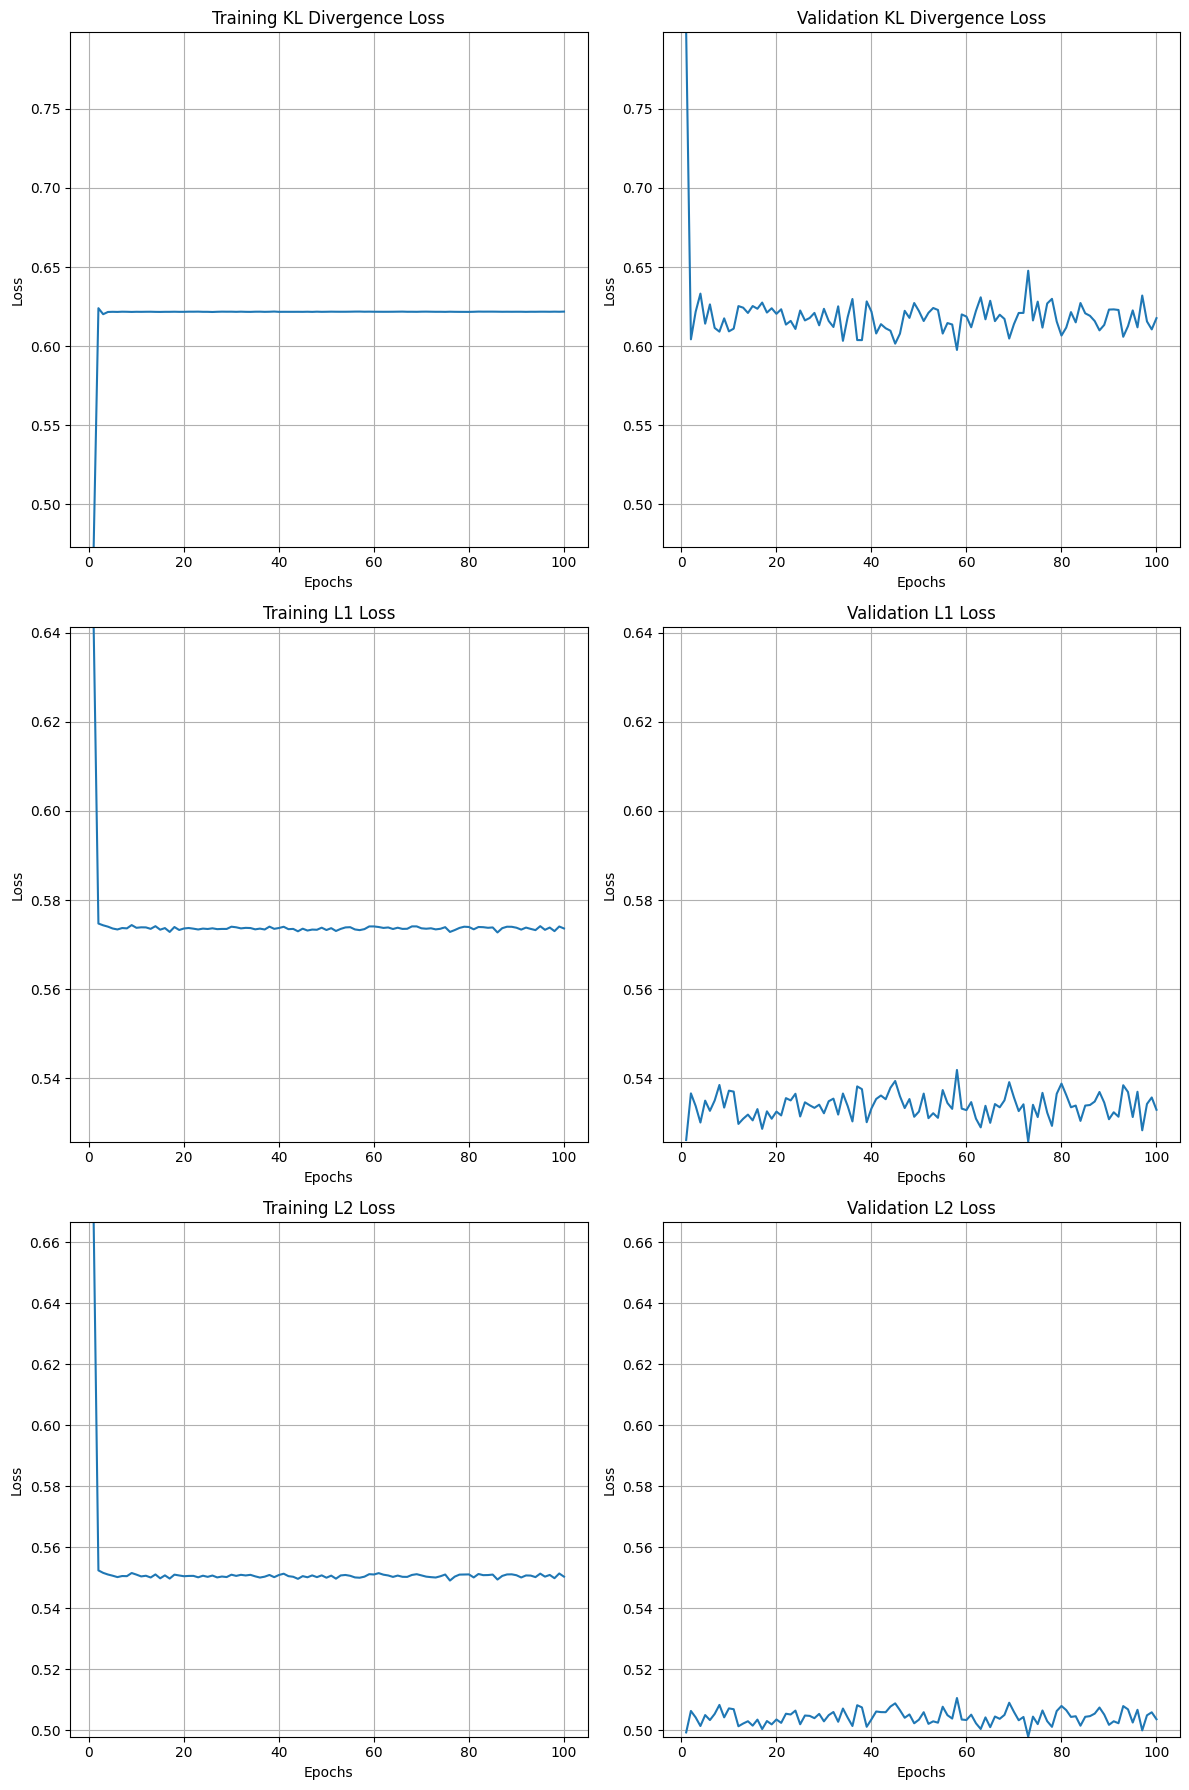

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
49.3287 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


z0: -0.0172
z1: 0.0040
z2: 0.0021
z3: 0.0099


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 759.27it/s]


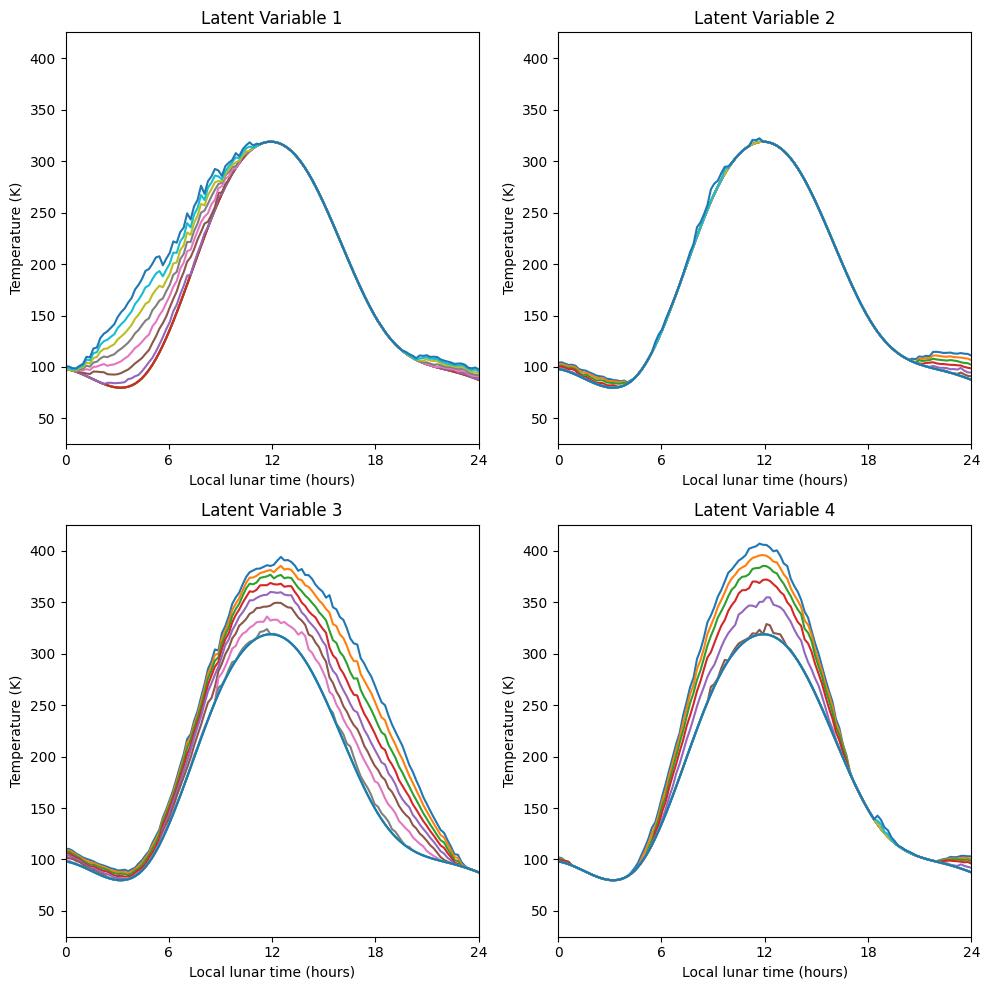

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)